# Learning a Generative Model of Images

In this project we will build a generative model for handwritten digits. First we load the data

In [2]:
import torchvision.datasets as dtset
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import sklearn.mixture as skm
import torchvision
from torch import nn

/Users/younismbs/anaconda3/envs/myEmv/lib/python3.8/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


In [3]:
# first of all download MNIST
dt_train = dtset.MNIST(root='.', download=True, train=True)
images_tr = dt_train.data.float()
labels_tr = dt_train.targets

# limit the pixel range to 0-1, and organize as a matrix
data = images_tr.reshape(images_tr.shape[0], -1)
data = data / data.max(-1, keepdim=True)[0]

print(images_tr.shape)

torch.Size([60000, 28, 28])


## Let's try learning a GMM first

Using sci-kit learn, learn a GMM on the images above. Then we generate images.

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True


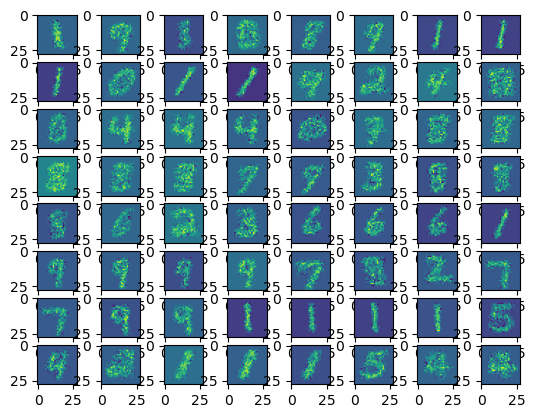

In [4]:
#The n_components parameter in a GMM controls the number of Gaussian components;
# too few leads to underfitting (blurry images), while too many causes overfitting (noisy or unrealistic images). 
# An optimal number captures the key features of the data without excessive complexity.
n_components = 100

GMM = skm.GaussianMixture(n_components= n_components, verbose=True, covariance_type='diag')
GMM.fit(data)

N = 64
samples = GMM.sample(N)[0]  # Generate N samples

samples = samples.reshape(N, 28, 28)

for n in range(0, 64):
   plt.subplot(8, 8, n+1)
   plt.imshow(samples[n])

## Let's improve these samples. So, first let's train an autoencoder for that...

We see that the samples above somehow follow the actual digits that we plot above also. However it seems like we can do better.

To improve the generated samples, an autoencoder with a convolutional architecture is trained:

- **Encoder**: Three convolutional layers to downsample the input images.
- **Bottleneck**: A compact latent space that represents key features.
- **Decoder**: Three transposed convolutional layers to reconstruct the images.

The autoencoder is trained to minimize reconstruction error, and its latent space is used for generating higher-quality samples with the GMM.


In [5]:
class conv_ae(nn.Module):
    def __init__(self, K=128):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, K, kernel_size=7)

        # Transposed convolution layers
        self.convt1 = nn.ConvTranspose2d(K, 64, kernel_size=7)
        self.convt2 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convt3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.nonl = nn.ReLU()

    def forward(self, x, verbose=False):
        h1 = self.conv1(x)
        h1 = self.nonl(h1)

        h2 = self.conv2(h1)
        h2 = self.nonl(h2)
    
        h3 = self.conv3(h2)

        h4 = self.convt1(h3)
        h4 = self.nonl(h4)

        h5 = self.convt2(h4)
        h5 = self.nonl(h5)

        xhat = self.convt3(h5)
        if verbose:
          print(h1.shape)
          print(h2.shape)
          print(h3.shape)

          print(h4.shape)
          print(h5.shape)
          print(xhat.shape)
        return torch.sigmoid(xhat), h3

    def decoder_forward(self, h):
      h4 = self.convt1(h)
      h4 = self.nonl(h4)
      h5 = self.convt2(h4)
      h5 = self.nonl(h5)
      xhat = self.convt3(h5)
      return torch.sigmoid(xhat)

**Training loop**

In [6]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    train_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, label = data
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

ep 0 loss val 2412384.0


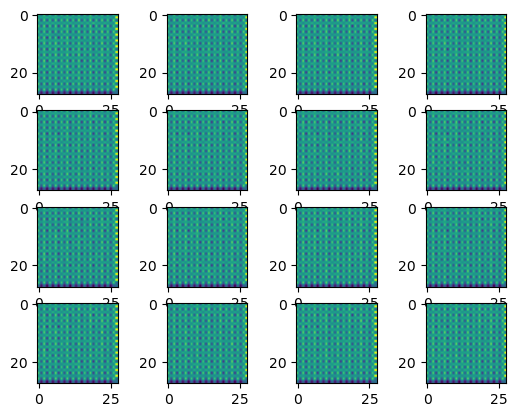

ep 100 loss val 957598.0


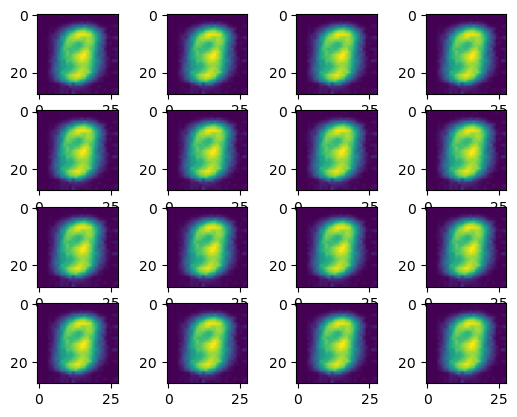

ep 200 loss val 913661.125


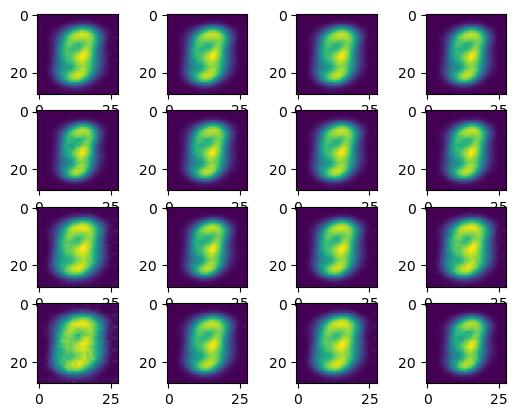

ep 300 loss val 665036.5


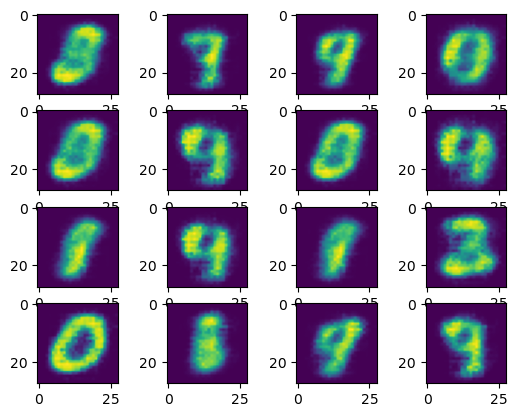

ep 400 loss val 401286.1875


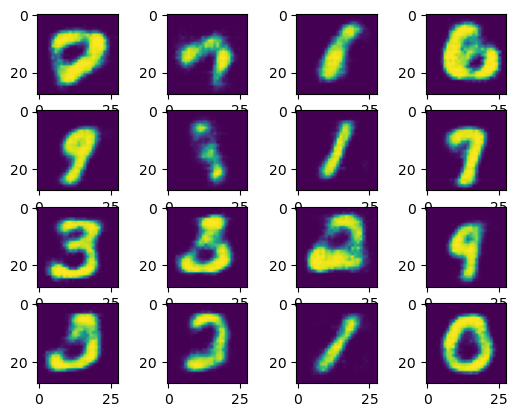

ep 500 loss val 280965.53125


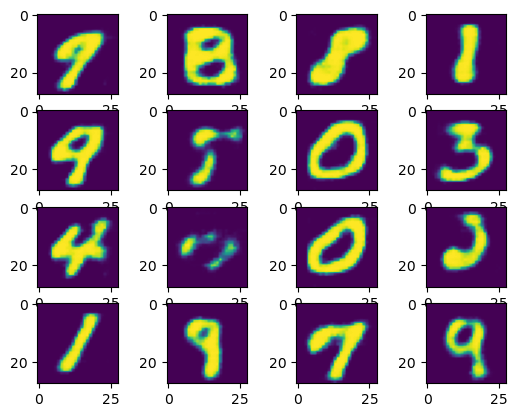

ep 600 loss val 220218.890625


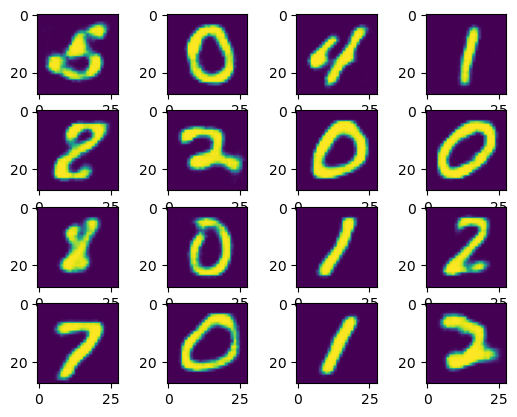

ep 700 loss val 196357.0


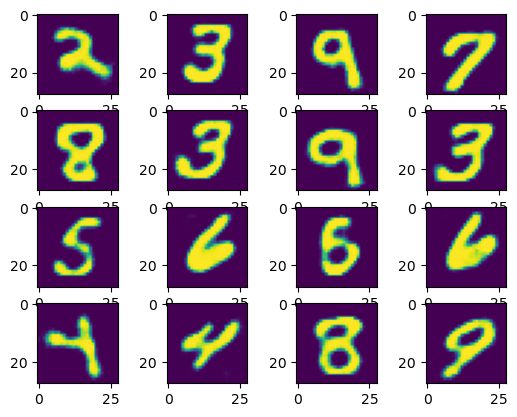

ep 800 loss val 167660.234375


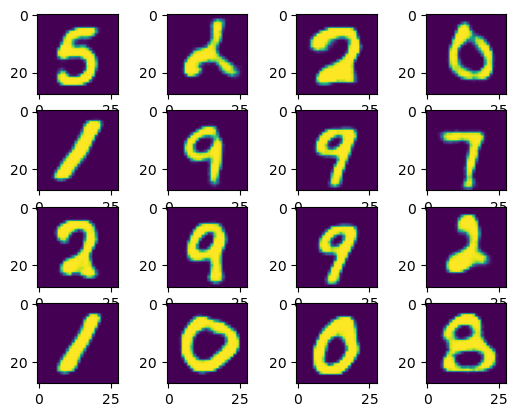

ep 900 loss val 150973.6875


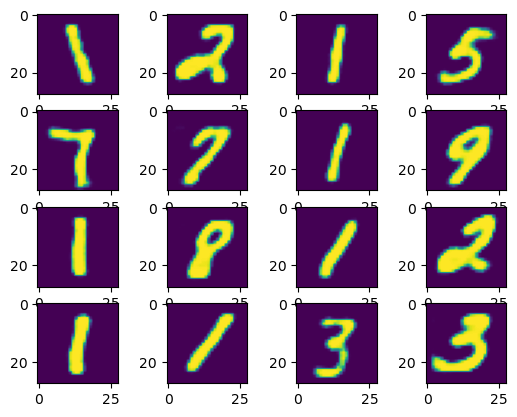

ep 1000 loss val 143424.0


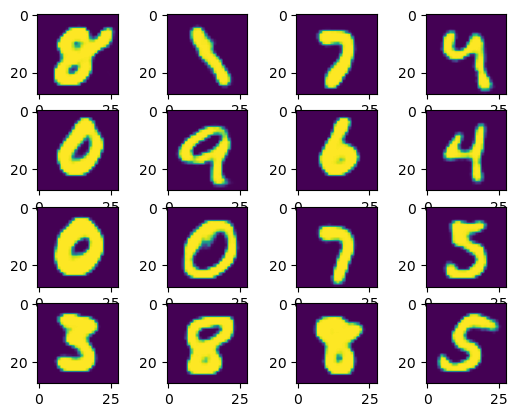

ep 1100 loss val 126115.8203125


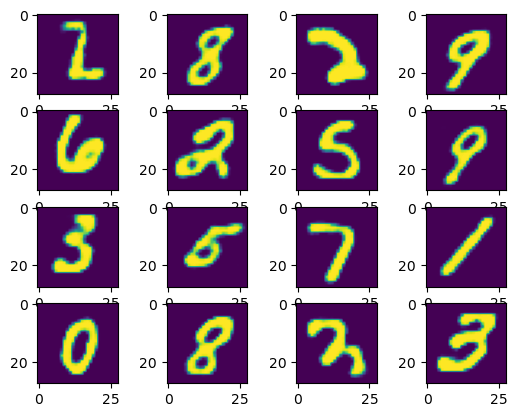

ep 1200 loss val 120180.5


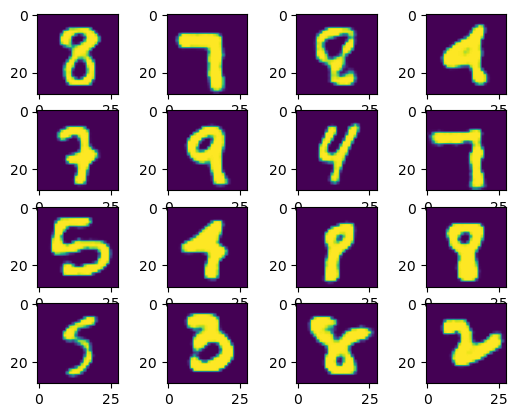

ep 1300 loss val 114391.8515625


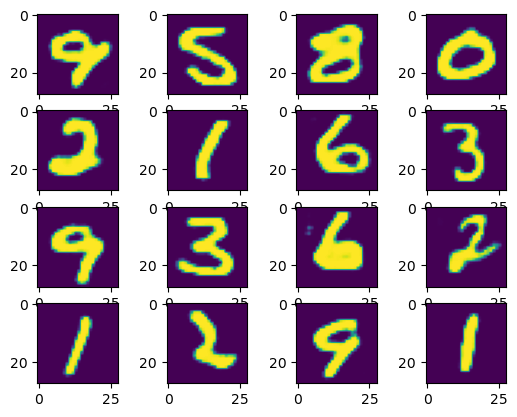

ep 1400 loss val 108271.59375


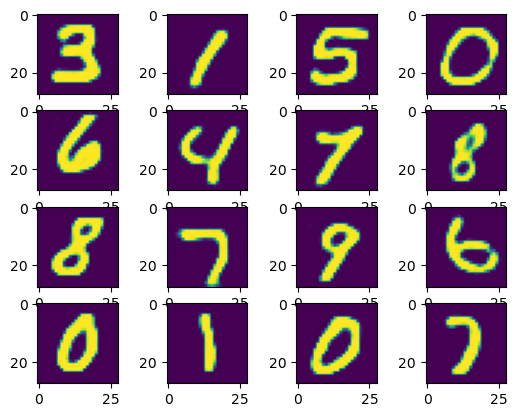

ep 1500 loss val 102695.859375


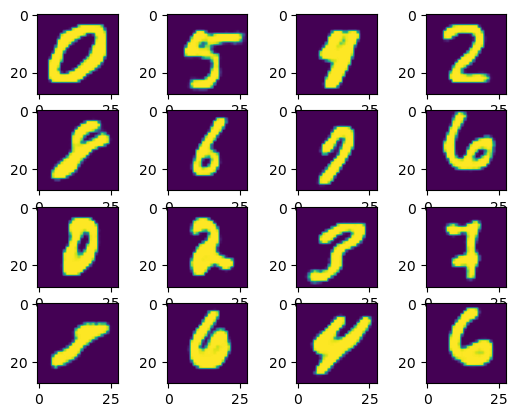

ep 1600 loss val 102130.5625


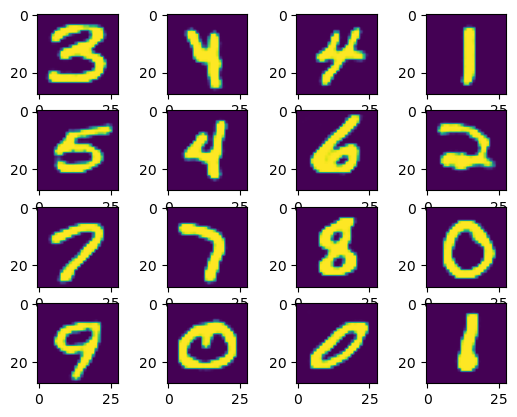

ep 1700 loss val 95803.359375


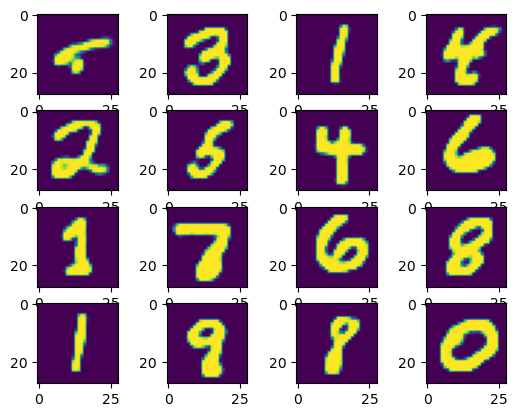

ep 1800 loss val 90630.5


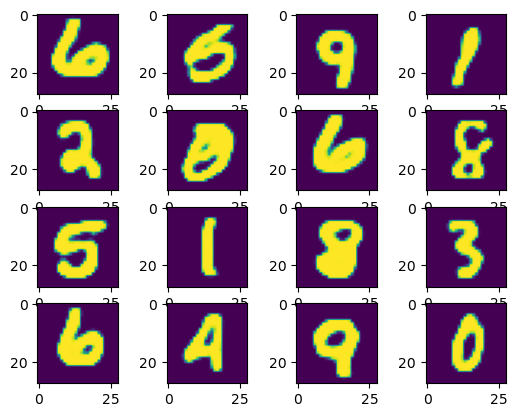

ep 1900 loss val 93580.640625


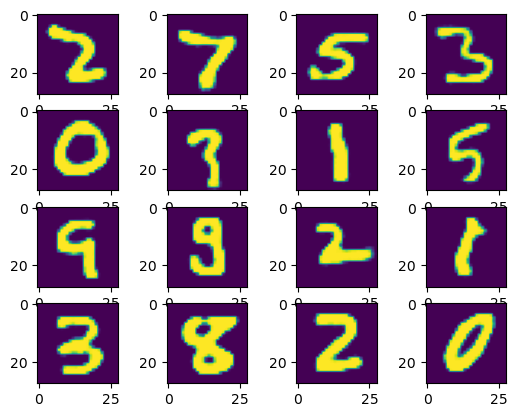

In [7]:
data = data.to('mps').reshape(-1, 1, 28, 28)
data[data > 0] = 1
model = conv_ae(K=128).to('mps')
_ = model.forward(data[:1000])

opt = torch.optim.Adam(params=model.parameters(), lr=2e-4)

eps = 1e-10
all_grads = []
batch_size = 4000
for e in range(2000):
    ind = torch.randint(0, data.shape[0] - batch_size, (1,))

    batch = data[ind:ind + batch_size]

    opt.zero_grad()
    out, _ = model.forward(batch)
    
    # Train with the negative Bernoulli likelihood loss
    epsilon = 1e-10
    loss = -torch.sum(batch * torch.log(out + epsilon) + (1 - batch) * torch.log(1 - out + epsilon))
    
    loss.backward()
    opt.step()

    if e % 100 == 0:
        print('ep {} loss val {}'.format(e, loss.item()))

        for n in range(0, 16):
            plt.subplot(4, 4, n + 1)
            plt.imshow(out.data.cpu()[n].squeeze())
        plt.show()

## Let's train a GMM in the latent space
To create a generative model in the autoencoder's latent space:

1. Pass the data $x_{1:N}$ through the encoder to obtain the latent codes $h_{1:N}$.
2. Fit a GMM on these latent codes $h_{1:N}$.
3. To generate new digits, sample from the learned GMM and pass the samples through the decoder.

In [8]:
# List to store latent codes
all_h = []
batch_size = 1000

# Process data in batches
for n in range(0, data.shape[0], batch_size):
    # Forward pass through the model to obtain latent codes
    _, hn = model.forward(data[n:n+batch_size])

    all_h.append(hn.detach().cpu().squeeze())

# Concatenate all latent codes from the batches
h_concat = torch.cat(all_h, dim=0)

# Print the shape of the concatenated latent codes
print(h_concat.shape)

torch.Size([60000, 128])


**Fitting a Gaussian to the latent codes**

In [9]:
n_components = 100 
GMM_latent = skm.GaussianMixture(n_components = n_components, verbose=True, covariance_type='diag')
GMM_latent.fit(h_concat)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
  Iteration 60
Initialization converged: True


GaussianMixture(covariance_type='diag', n_components=100, verbose=True)

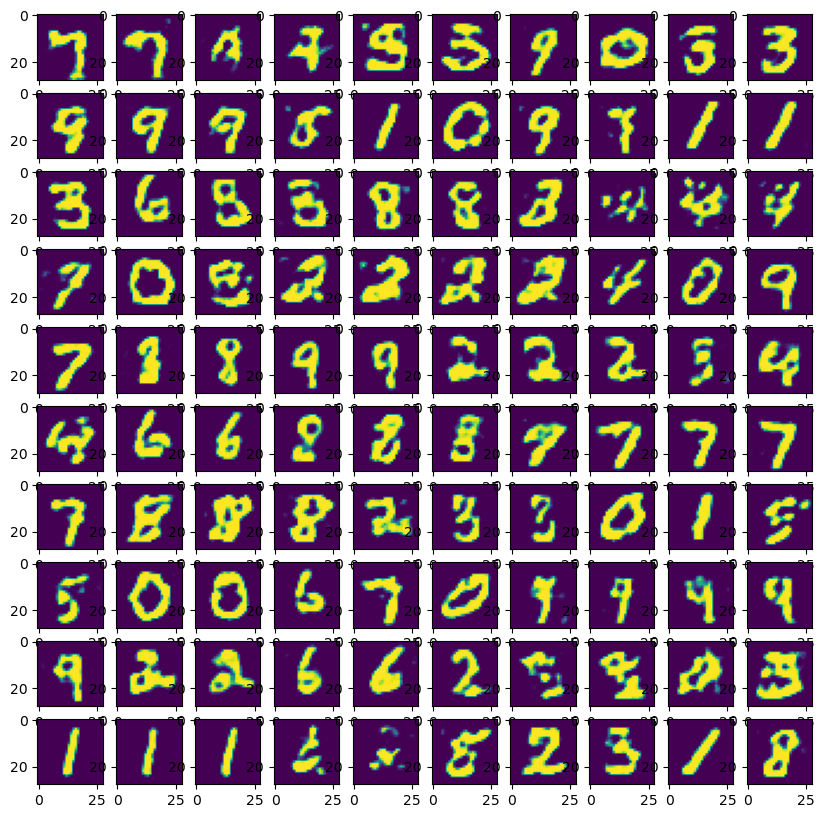

In [10]:
# Sample 100 points from the GMM latent space
latent_samples = GMM_latent.sample(100)[0]
latent_samples = latent_samples.astype(np.float32)

res = torch.from_numpy(latent_samples).unsqueeze(-1).unsqueeze(-1).to('mps')

# Pass the samples through the decoder to generate images
samples = model.decoder_forward(res)

# Plot the generated images in a 10x10 grid
plt.figure(figsize=[10, 10], dpi=100)
for n in range(0, 100):
    plt.subplot(10, 10, n + 1)
    plt.imshow(samples[n].squeeze().data.cpu())